In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('bank_transactions.csv')

df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [20]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%d/%m/%y', errors='coerce')

df = df.dropna()

df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], format='%d/%m/%y', errors='coerce')
df['CustomerAge'] = (pd.to_datetime('today') - df['CustomerDOB']).dt.days // 365

df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,143207,25.0,30.0
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-08-02,141858,27999.0,-33.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,142712,459.0,27.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,142714,2060.0,51.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-08-02,181156,1762.5,36.0


In [21]:
df = pd.get_dummies(df, columns=['CustLocation', 'CustGender'], drop_first=True)

df['TransactionAmount (INR)'] = df['TransactionAmount (INR)'].astype(float)
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'], unit='s')

df['TransactionHourOfDay'] = df['TransactionTime'].dt.hour
df['TransactionDayOfWeek'] = df['TransactionTime'].dt.dayofweek

customer_summary = df.groupby('CustomerID').agg(
    avg_balance=('CustAccountBalance', 'mean'),
    avg_transaction_amount=('TransactionAmount (INR)', 'mean'),
    transaction_frequency=('TransactionID', 'count'),
    avg_age=('CustomerAge', 'mean'),
    avg_day_of_week=('TransactionDayOfWeek', 'mean'),
    avg_hour_of_day=('TransactionHourOfDay', 'mean')
).reset_index()

customer_summary.head()


,CustomerID,avg_balance,avg_transaction_amount,transaction_frequency,avg_age,avg_day_of_week,avg_hour_of_day
0,C1010011,76340.635,2553.0,2,36.5,3.5,6.5
1,C1010012,24204.490,1499.0,1,30.0,5.0,8.0
2,C1010014,100112.950,727.5,2,36.0,4.5,15.5
3,C1010018,496.180,30.0,1,34.0,4.0,23.0
4,C1010024,87058.650,5000.0,1,-41.0,4.0,15.0


In [22]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_summary.drop('CustomerID', axis=1))

scaled_features[:5]

array([[-0.04790311,  0.15329836,  1.81640799,  0.17926772, -1.41006983,
        -0.63239207],
       [-0.11298516, -0.0105381 , -0.41099187, -0.20104884,  1.03981506,
        -0.39136397],
       [-0.0182279 , -0.13046204,  1.81640799,  0.1500126 ,  0.22318677,
         0.81377654],
       [-0.14258047, -0.23888323, -0.41099187,  0.03299212, -0.59344153,
         2.01891706],
       [-0.03452371,  0.53366632, -0.41099187, -4.35527586, -0.59344153,
         0.73343384]])

In [23]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Cluster Centers:
 [[-1.79793700e-02 -4.72138668e-02 -4.10991874e-01]
 [-9.46602277e-03 -2.33430991e-02  2.13551399e+00]
 [ 4.21434396e-01  1.03662648e+01 -1.72911668e-01]
 [ 3.32564088e+01  8.18236031e-01 -9.76747575e-02]]


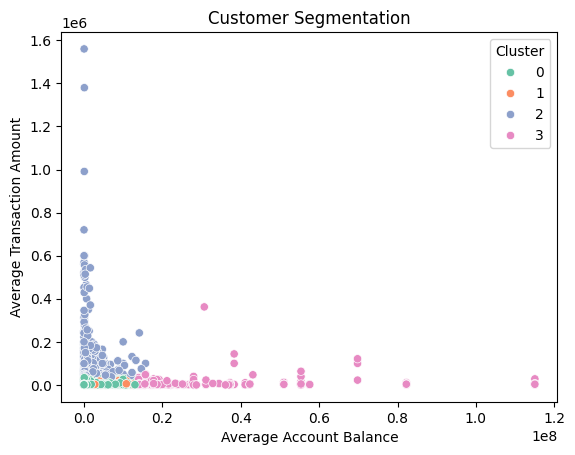

In [11]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

customer_summary['Cluster'] = kmeans.fit_predict(scaled_features)

# Display the cluster centers
print("Cluster Centers:\n", kmeans.cluster_centers_)

sns.scatterplot(x='avg_balance', y='avg_transaction_amount', hue='Cluster', data=customer_summary, palette='Set2')
plt.title('Customer Segmentation')
plt.xlabel('Average Account Balance')
plt.ylabel('Average Transaction Amount')
plt.legend(title='Cluster')
plt.show()


In [12]:
cluster_summary = customer_summary.groupby('Cluster').agg(
    avg_balance=('avg_balance', 'mean'),
    avg_transaction_amount=('avg_transaction_amount', 'mean'),
    transaction_frequency=('transaction_frequency', 'mean')
).reset_index()

print("Cluster Characteristics:\n", cluster_summary)

Cluster Characteristics:
    Cluster   avg_balance  avg_transaction_amount  transaction_frequency
0        0  1.003122e+05             1263.101523               1.000000
1        1  1.071319e+05             1416.622301               2.143264
2        2  4.523870e+05            68264.727585               1.106917
3        3  2.675587e+07             6830.706488               1.140665
